In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 8
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/diego/local_repos/AGEC652_2024/AGEC652_2024/slides/lecture_6_2"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| include: false
using Pkg
Pkg.activate(".")
Pkg.instantiate()
# Pkg.add("JuMP")
# Pkg.add("Ipopt")
# Pkg.add("Statistics")
# Pkg.add("Plots")
# Pkg.add("ForwardDiff")
# Pkg.add("LinearAlgebra")
# Pkg.add("LaTeXStrings")
Pkg.add("GLM")
# Pkg.add("DataFrames")
# Pkg.add("Distributions")

  Activating project at `~/local_repos/AGEC652_2024/AGEC652_2024/slides/lecture_6_2`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/AGEC652_2024/slides/lecture_6_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/AGEC652_2024/slides/lecture_6_2/Manifest.toml`


In [3]:
using Random, Distributions
Random.seed!(652); # For reproducibility
N = 1000;
μ_u = 1;
σ_u = 3;
u_is = rand(Normal(μ_u, σ_u), N);

In [4]:
p = 2;
y_is = (u_is .- p .> 0);

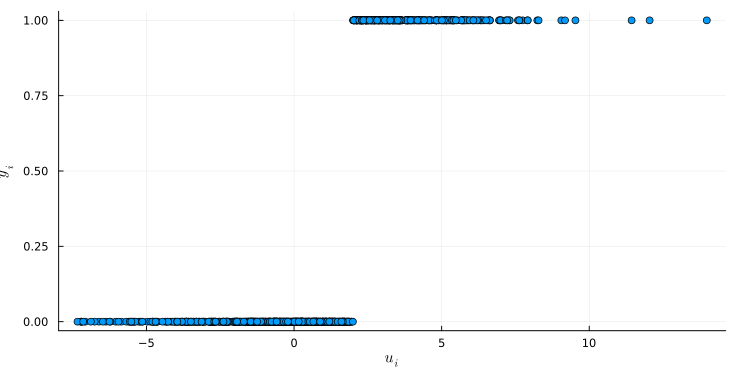

In [5]:
using Plots, LaTeXStrings
Plots.scatter(u_is, y_is, xlabel=L"$u_i$", ylabel=L"$y_i$", label="")

In [6]:
println("We know that $(mean(y_is)*100)% of consumers have u > p")

We know that 36.0% of consumers have u > p


In [7]:
1 - cdf(Normal(μ_u, σ_u), p)

0.36944134018176367

In [8]:
p_grid = collect(-10:10)
# Rows are individuals i, columns are prices
Z = [(u - p > 0) for u in u_is, p in p_grid]

1000×21 Matrix{Bool}:
 1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮              ⋮              ⋮
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1 

In [9]:
s_p = zeros(length(p_grid))
for j in 1:length(p_grid)
  s_p[j] = mean(Z[:,j]) # Calculate mean of column j
end

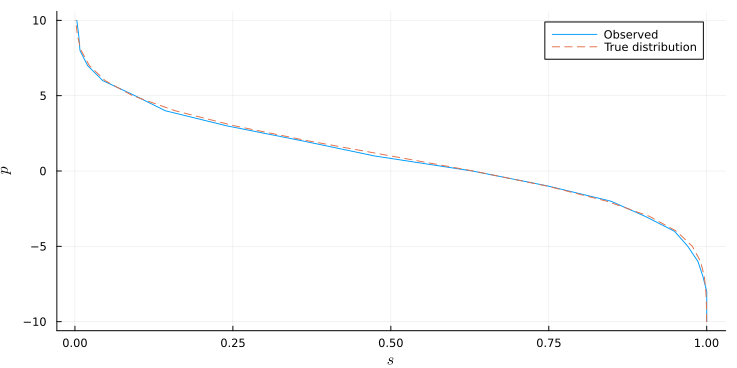

In [10]:
plot(s_p, p_grid, xlabel=L"$s$", ylabel=L"$p$", label="Observed")
plot!(1 .- cdf.(Normal(μ_u, σ_u), p_grid), p_grid, linestyle=:dash, label="True distribution")

In [11]:
using Random, Distributions
Random.seed!(652)
N = 1000
x_is = rand(Uniform(-2.0, 2.0), N) # x ~ U[2, 2]
v_is = rand(Normal(), N) # ν ~ N(0,1)
β_0_true = 2.0 
β_1_true = 3.0
y_is_star = β_0_true .+ β_1_true .* x_is .+ v_is; # Latent variable

In [12]:
y_is = (y_is_star .> 0);

In [13]:
using GLM
X = hcat(ones(length(x_is)), x_is) # Form matrix X with a columns of 1s
ols_model = lm(X, y_is)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────
       Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────
x1  0.658381  0.00911022  72.27    <1e-99   0.640503   0.676258
x2  0.325934  0.00785649  41.49    <1e-99   0.310516   0.341351
───────────────────────────────────────────────────────────────


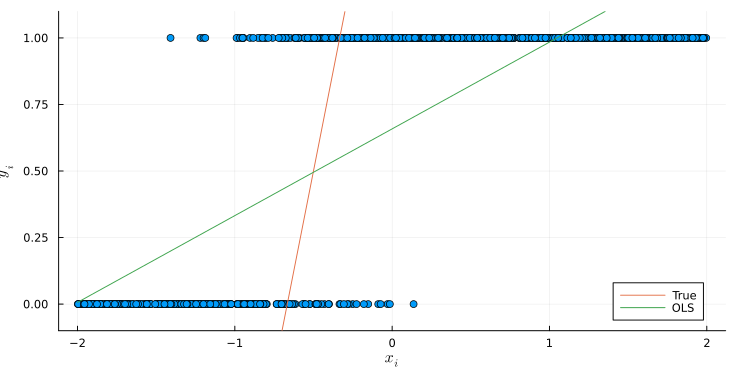

In [14]:
Plots.scatter(x_is, y_is, label = "", xlabel = L"x_i", ylabel = L"y_i", ylim = [-0.1, 1.1])
plot!(x -> β_0_true+β_1_true*x, range(-2.0, 2.0, 100), label = "True")
plot!(x -> coef(ols_model)[1]+coef(ols_model)[2]*x, range(-2.0, 2.0, 100), label = "OLS")

In [15]:
Φ(z) = cdf(Normal(), z) # Define our Φ
# We will define the negative of log-likelihood for optimization
neg_l_probit(β) = -sum((1 .- y_is).*log.(Φ.(-X*β)) .+ y_is.*log.(Φ.(X*β)) );

In [16]:
using Optim
opt_res = Optim.optimize(neg_l_probit, [0.0, 0.0], BFGS())
β_MLE = opt_res.minimizer

[ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]


2-element Vector{Float64}:
 1.7972312529104952
 2.8340303185054556

In [17]:
using ForwardDiff, LinearAlgebra
Im = -ForwardDiff.hessian(neg_l_probit, β_MLE) # Flip the signs
V = inv(Im);
SEs = sqrt.(diag(-V));

In [18]:
using DataFrames, Distributions
df = DataFrame(
  Coefficient = ["beta_0", "beta_1"],
  Estimate = β_MLE,
  StdError = SEs,
  CI_lower = β_MLE .+ quantile(Normal(), 0.025) .* SEs,
  CI_upper = β_MLE .+ quantile(Normal(), 0.975) .* SEs
)
println(df)

2×5 DataFrame
 Row │ Coefficient  Estimate  StdError  CI_lower  CI_upper 
     │ String       Float64   Float64   Float64   Float64  
─────┼─────────────────────────────────────────────────────
   1 │ beta_0        1.79723  0.149244   1.50472   2.08974
   2 │ beta_1        2.83403  0.201974   2.43817   3.22989


In [19]:
my_df = DataFrame(X = x_is, Y = y_is)
glm_model = glm(@formula(Y ~ 1 + X), my_df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  1.79726    0.150937  11.91    <1e-31    1.50143    2.09309
X            2.83404    0.203046  13.96    <1e-43    2.43608    3.23201
───────────────────────────────────────────────────────────────────────